
# ISOLET Case Study 


Load dependencies and provide a helper that installs missing packages on the fly.

In [4]:

import sys, subprocess, importlib, time
from pathlib import Path

def ensure(pkg):
    """Import a package or install it quickly if it is missing."""
    try:
        return importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        return importlib.import_module(pkg)

np   = ensure("numpy")
pd   = ensure("pandas")
plt  = ensure("matplotlib.pyplot")
sns  = ensure("seaborn"); sns.set_style("whitegrid")

sk_metrics = ensure("sklearn.metrics")
sk_preproc = ensure("sklearn.preprocessing")
sk_decomp  = ensure("sklearn.decomposition")
sk_cluster = ensure("sklearn.cluster")
sk_mixture = ensure("sklearn.mixture")
sk_nn      = ensure("sklearn.neighbors")

ucimlrepo  = ensure("ucimlrepo")
try:
    KneeLocator = ensure("kneed").KneeLocator
except Exception:
    KneeLocator = None

from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

METHOD_COLORS = {
    "KMeans":        "#4477AA",
    "Agglomerative": "#228833",
    "GMM":           "#EE6677",
    "DBSCAN":        "#AA3377",
}
ACCENT_ELBOW = "#CCBB44"
ACCENT_VAR   = "#1F1F1F"

def legend_outside(ax=None):
    """Place the legend just outside the right edge for clean plots."""
    (ax or plt).legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True)

RANDOM_STATE = 42
SHOW_EDA  = False
SAVE_FIGS = False  # display-only mode
print("ISOLET pipeline starting")  # simple start note


ISOLET pipeline starting


Fetch ISOLET from UCI and standardize its features.

In [6]:

isolet = ucimlrepo.fetch_ucirepo(id=54)
X = isolet.data.features.values
y_raw = isolet.data.targets.values.ravel()
y, _ = pd.factorize(y_raw)
C = len(np.unique(y))
print(f"Data shape X={X.shape}, classes={C}")

scaler = sk_preproc.StandardScaler()
X_scaled = scaler.fit_transform(X)


Data shape X=(7797, 617), classes=26


Run a light missingness and robust outlier scan to sanity check the matrix.

In [8]:

n_missing = int(np.isnan(X_scaled).sum())
med = np.median(X_scaled, axis=0)
mad = np.median(np.abs(X_scaled - med), axis=0) + 1e-9
robust_z = np.abs((X_scaled - med) / (1.4826 * mad))
n_extreme = int((robust_z > 5).any(axis=1).sum())
print(f"Missing values in X: {n_missing}")
print(f"Samples with any very-extreme feature (|robust z|>5): {n_extreme} of {X_scaled.shape[0]}")


Missing values in X: 0
Samples with any very-extreme feature (|robust z|>5): 7504 of 7797


Optionally peek at class counts across A–Z for a quick feel of balance.

In [10]:

if SHOW_EDA:
    letters = [chr(ord('A')+i) for i in range(C)]
    counts = pd.Series(y).value_counts().sort_index()
    plt.figure(figsize=(9,4))
    plt.bar(letters, counts.values)
    plt.xlabel("Letter class"); plt.ylabel("Count")
    plt.title("ISOLET class distribution")
    plt.tight_layout()
    plt.show()


Define small helpers for metrics, elbows, eps picking, DBSCAN stats, and mapping.

In [12]:

def safe_internal_metrics(Xp, labels):
    """Return silhouette and DBI or NaNs when clusters are invalid."""
    uniq = np.unique(labels)
    if len(uniq) < 2 or (len(uniq) == 1 and uniq[0] == -1):
        return np.nan, np.nan
    try:
        sil = sk_metrics.silhouette_score(Xp, labels)
    except Exception:
        sil = np.nan
    try:
        dbi = sk_metrics.davies_bouldin_score(Xp, labels)
    except Exception:
        dbi = np.nan
    return sil, dbi

def elbow_wcss(Xp, k_range):
    """Compute WCSS over k and find an elbow with KneeLocator if available."""
    wcss = []
    for k in k_range:
        km = sk_cluster.KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=RANDOM_STATE)
        km.fit(Xp)
        wcss.append(km.inertia_)
    elbow_k = None
    if KneeLocator is not None:
        kl = KneeLocator(list(k_range), wcss, S=1.0, curve="convex", direction="decreasing")
        elbow_k = kl.elbow
    return wcss, elbow_k

def pick_eps_from_kdist(Xp, min_samples, fallback_percentile=95):
    """Pick DBSCAN eps from the k-distance knee with a percentile fallback."""
    nns = sk_nn.NearestNeighbors(n_neighbors=min(min_samples, len(Xp)-1))
    distances, _ = nns.fit(Xp).kneighbors(Xp)
    k_dist = np.sort(distances[:, -1])
    if KneeLocator is not None:
        idx = np.arange(len(k_dist))
        kl = KneeLocator(idx, k_dist, S=1.0, curve="convex", direction="increasing")
        if kl.knee is not None:
            return float(k_dist[int(kl.knee)]), k_dist, int(kl.knee)
    return float(np.percentile(k_dist, fallback_percentile)), k_dist, None

def dbscan_stats(labels):
    """Return number of clusters and noise fraction for DBSCAN labels."""
    n_noise = int((labels == -1).sum())
    n_clusters = len(np.unique(labels[labels != -1]))
    return n_clusters, n_noise / len(labels)

def map_clusters_to_classes(y_true, y_pred):
    """Map clusters to classes with Hungarian assignment while preserving noise."""
    mask = (y_pred != -1)
    C = contingency_matrix(y_true[mask], y_pred[mask])
    r_ind, c_ind = linear_sum_assignment(C.max() - C)
    mapped = np.full_like(y_pred, fill_value=-1)
    cl_nonnoise = np.unique(y_pred[mask])
    mapping = {cl_nonnoise[c]: int(r) for r,c in zip(r_ind, c_ind)}
    for i, cl in enumerate(y_pred):
        mapped[i] = mapping.get(cl, -1)
    acc = (y_true == mapped).mean()
    return mapped, mapping, float(acc)

def plot_confusion_mapped(y_true, y_pred, title, normalize="row", show_numbers=True, decimals=1,
                          min_pct_to_annot=0.0, cmap="Greens"):
    """Draw a Hungarian-mapped confusion heatmap with percentages and counts."""
    y_map, mapping, acc = map_clusters_to_classes(y_true, y_pred)
    classes = sorted(np.unique(y_true))
    has_noise = np.any(y_map == -1)
    label_order = classes + ([-1] if has_noise else [])

    cm_counts = confusion_matrix(y_true, y_map, labels=label_order).astype(int)
    if normalize == "row":
        with np.errstate(invalid="ignore", divide="ignore"):
            row_sums = cm_counts.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1
            cm = cm_counts / row_sums
        cbar_label = "Row-normalised proportion"
    else:
        cm = cm_counts.astype(float)
        cbar_label = "Proportion"

    if len(classes) == 26 and set(classes) == set(range(26)):
        tick_labels = [chr(ord('A') + i) for i in classes] + (["Noise"] if has_noise else [])
    else:
        tick_labels = [str(i) for i in classes] + (["Noise"] if has_noise else [])

    annot = None
    if show_numbers:
        annot = np.empty_like(cm).astype(object)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                pct = 100.0 * cm[i, j]
                annot[i, j] = f"{pct:.{decimals}f}%\n({cm_counts[i, j]})" if pct >= min_pct_to_annot else ""

    plt.figure(figsize=(12, 9))
    ax = sns.heatmap(cm, cmap=cmap, vmin=0, vmax=1 if normalize == "row" else None,
                     xticklabels=tick_labels, yticklabels=tick_labels,
                     cbar_kws={"label": cbar_label}, annot=annot, fmt="", annot_kws={"size": 8})
    ax.set_xlabel("Predicted (mapped)")
    ax.set_ylabel("True class")
    plt.tight_layout()
    plt.show()
    return cm_counts, cm, acc


Reduce to 50 principal components and report the explained variance share.

In [14]:

PCA_NC = 50
pca50 = sk_decomp.PCA(n_components=PCA_NC, svd_solver="full", random_state=RANDOM_STATE)
X_pca50 = pca50.fit_transform(X_scaled)
expl_var_50 = float(pca50.explained_variance_ratio_.sum())
print(f"PCA=50 explained variance ≈ {expl_var_50:.3f}")


PCA=50 explained variance ≈ 0.804


Find a KMeans elbow and choose DBSCAN eps from a k-distance knee or percentile.

Elbow suggests k≈11; using k=26 to match true classes.
DBSCAN params for PCA=50 are min_samples=100 and eps≈25.088


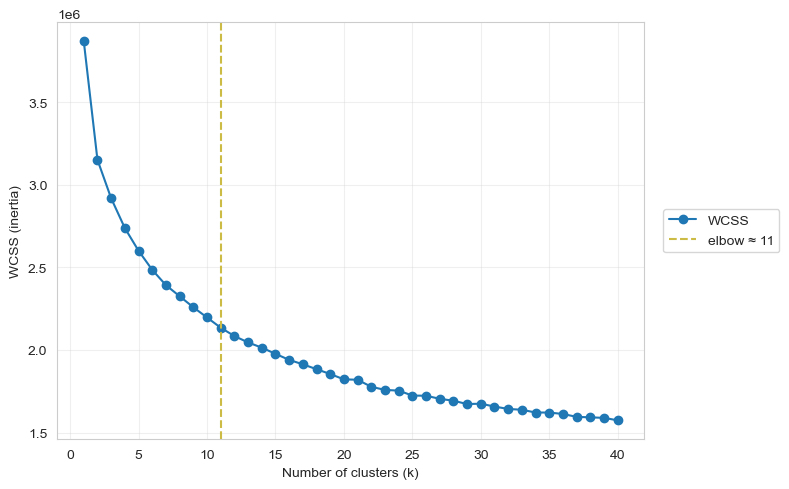

In [16]:

K_RANGE = range(1, 41)
wcss, elbow_k = elbow_wcss(X_pca50, K_RANGE)

K_TRUE = len(np.unique(y))
k_used = K_TRUE
print(f"Elbow suggests k≈{elbow_k}; using k={k_used} to match true classes.")

min_samples_50 = max(5, 2*PCA_NC)
eps_50, kdist_50, knee_idx_50 = pick_eps_from_kdist(X_pca50, min_samples_50)
print(f"DBSCAN params for PCA=50 are min_samples={min_samples_50} and eps≈{eps_50:.3f}")

plt.figure(figsize=(8,5))
plt.plot(list(K_RANGE), wcss, marker="o", label="WCSS")
if elbow_k is not None:
    plt.axvline(elbow_k, color=ACCENT_ELBOW, linestyle="--", label=f"elbow ≈ {elbow_k}")
plt.xlabel("Number of clusters (k)"); plt.ylabel("WCSS (inertia)")
legend_outside()
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.show()


Fit KMeans, Agglomerative, GMM, and DBSCAN on PCA=50 and build a concise summary table.

In [18]:

def fit_score_time(model, Xp, y_true):
    """Fit a model, return labels, ARI, silhouette, and elapsed seconds."""
    t1 = time.perf_counter()
    labels = model.fit_predict(Xp) if hasattr(model, "fit_predict") else model.fit(Xp).predict(Xp)
    t2 = time.perf_counter()
    ari = sk_metrics.adjusted_rand_score(y_true, labels)
    sil, _ = safe_internal_metrics(Xp, labels)
    return labels, ari, sil, (t2 - t1)

kmeans_50 = sk_cluster.KMeans(n_clusters=k_used, init="k-means++", n_init=10, random_state=RANDOM_STATE)
agg_50    = sk_cluster.AgglomerativeClustering(n_clusters=k_used, linkage="ward")
gmm_50    = sk_mixture.GaussianMixture(n_components=k_used, covariance_type="full",
                                       init_params="kmeans", reg_covar=1e-6, random_state=RANDOM_STATE)
dbscan_50 = sk_cluster.DBSCAN(eps=eps_50, min_samples=min_samples_50)

labels_km, ari_km, sil_km, t_km = fit_score_time(kmeans_50, X_pca50, y)
labels_ag, ari_ag, sil_ag, t_ag = fit_score_time(agg_50,    X_pca50, y)
labels_gm, ari_gm, sil_gm, t_gm = fit_score_time(gmm_50,    X_pca50, y)
labels_db, ari_db, sil_db, t_db = fit_score_time(dbscan_50, X_pca50, y)

km_ncl  = len(np.unique(labels_km));  km_noise  = 0.0
ag_ncl  = len(np.unique(labels_ag));  ag_noise  = 0.0
gm_ncl  = len(np.unique(labels_gm));  gm_noise  = 0.0
def _dbscan_stats(lbls):
    """Light wrapper to report DBSCAN clusters and noise rate."""
    return dbscan_stats(lbls)
db_ncl, db_noise = _dbscan_stats(labels_db)

summary_50 = pd.DataFrame([
    ["KMeans",        PCA_NC, k_used, eps_50, min_samples_50, ari_km, sil_km, t_km, km_ncl, km_noise],
    ["Agglomerative", PCA_NC, k_used, eps_50, min_samples_50, ari_ag, sil_ag, t_ag, ag_ncl, ag_noise],
    ["GMM",           PCA_NC, k_used, eps_50, min_samples_50, ari_gm, sil_gm, t_gm, gm_ncl, gm_noise],
    ["DBSCAN",        PCA_NC, float('nan'), eps_50, min_samples_50, ari_db, sil_db, t_db, db_ncl, db_noise],
], columns=["Method","PCA_components","k_used","DBSCAN_eps","DBSCAN_min_samples",
            "ARI","Silhouette","ExecTime_s","Clusters_found","Noise_fraction"]).round(4)

print("PCA=50 summary table")
display(summary_50)


PCA=50 summary table


,Method,PCA_components,k_used,DBSCAN_eps,DBSCAN_min_samples,ARI,Silhouette,ExecTime_s,Clusters_found,Noise_fraction
0,KMeans,50,26.0,25.0876,100,0.4464,0.1089,1.2458,26,0.0000
1,Agglomerative,50,26.0,25.0876,100,0.4818,0.0988,3.4797,26,0.0000
2,GMM,50,26.0,25.0876,100,0.4989,0.0896,12.9800,26,0.0000
3,DBSCAN,50,NaN,25.0876,100,0.0001,0.3084,0.7996,1,0.0074


Relate ARI to cumulative explained variance for a clear tradeoff view.

ARI vs PCA grid


,PCA,Method,ARI
0,10,KMeans,0.384464
1,10,Agglomerative,0.402242
2,10,GMM,0.428381
3,10,DBSCAN,0.000003
4,20,KMeans,0.454502
5,20,Agglomerative,0.435770
6,20,GMM,0.454725
7,20,DBSCAN,0.000042
8,30,KMeans,0.462930
9,30,Agglomerative,0.479083


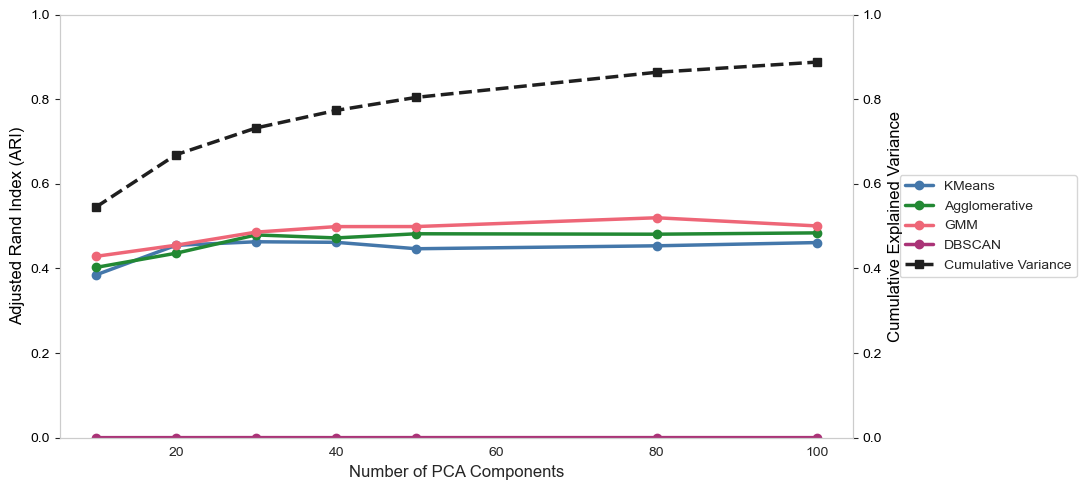

In [20]:

pca_grid = [10, 20, 30, 40, 50, 80, 100]
rows = []
for nc in pca_grid:
    Xp = sk_decomp.PCA(n_components=nc, svd_solver="full", random_state=RANDOM_STATE).fit_transform(X_scaled)
    km  = sk_cluster.KMeans(n_clusters=k_used, init="k-means++", n_init=10, random_state=RANDOM_STATE)
    ag  = sk_cluster.AgglomerativeClustering(n_clusters=k_used, linkage="ward")
    gm  = sk_mixture.GaussianMixture(n_components=k_used, covariance_type="full",
                                     init_params="kmeans", reg_covar=1e-6, random_state=RANDOM_STATE)
    lab_km = km.fit_predict(Xp)
    lab_ag = ag.fit_predict(Xp)
    lab_gm = gm.fit(Xp).predict(Xp)
    ms = max(5, 2*nc)
    eps_nc, _, _ = pick_eps_from_kdist(Xp, min_samples=ms)
    lab_db = sk_cluster.DBSCAN(eps=eps_nc, min_samples=ms).fit_predict(Xp)
    ARI = sk_metrics.adjusted_rand_score
    rows += [
        {"PCA": nc, "Method":"KMeans",        "ARI":ARI(y, lab_km)},
        {"PCA": nc, "Method":"Agglomerative", "ARI":ARI(y, lab_ag)},
        {"PCA": nc, "Method":"GMM",           "ARI":ARI(y, lab_gm)},
        {"PCA": nc, "Method":"DBSCAN",        "ARI":ARI(y, lab_db)},
    ]
df = pd.DataFrame(rows)
print("ARI vs PCA grid")
display(df)

pca_full = sk_decomp.PCA(n_components=100, svd_solver="full", random_state=RANDOM_STATE)
pca_full.fit(X_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

fig, ax1 = plt.subplots(figsize=(11, 5))
for method in ["KMeans", "Agglomerative", "GMM", "DBSCAN"]:
    sub_df = df[df["Method"] == method]
    ax1.plot(sub_df["PCA"], sub_df["ARI"], marker="o", label=method, lw=2.5,
             color=METHOD_COLORS[method])
ax1.set_xlabel("Number of PCA Components", fontsize=12)
ax1.set_ylabel("Adjusted Rand Index (ARI)", fontsize=12, color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.set_ylim(0, 1.0)
ax1.grid(False)

ax2 = ax1.twinx()
variance_to_plot = [cumulative_variance[i-1] for i in pca_grid]
ax2.plot(pca_grid, variance_to_plot, color=ACCENT_VAR, linestyle='--', marker='s',
         label='Cumulative Variance', lw=2.5)
ax2.set_ylabel("Cumulative Explained Variance", fontsize=12, color="black")
ax2.tick_params(axis='y', labelcolor="black")
ax2.set_ylim(0, 1.0)
ax2.grid(False)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=True)
fig.tight_layout()
plt.show()


Pick the best ARI method at PCA=50 and show the mapped confusion heatmap.

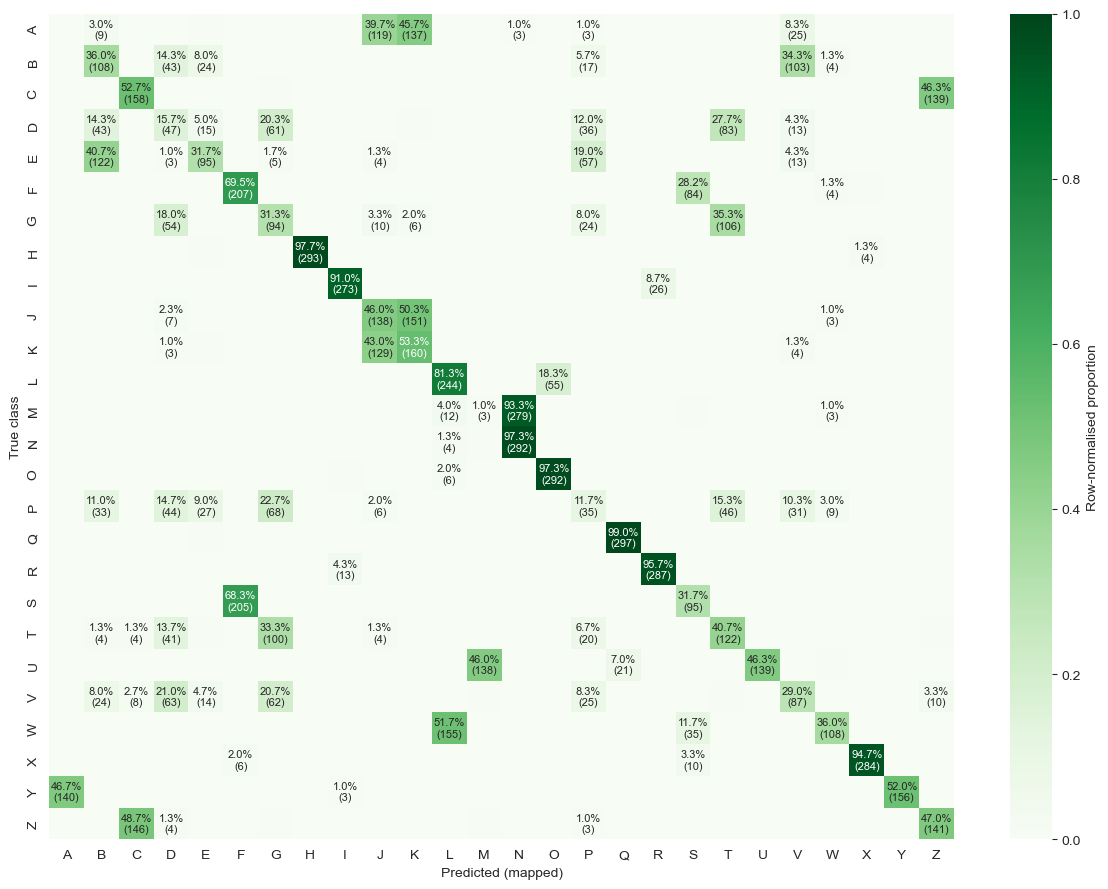

In [33]:

best_row = summary_50.iloc[summary_50["ARI"].idxmax()]
best_name = best_row["Method"]
labels_best = {"KMeans":labels_km, "Agglomerative":labels_ag, "GMM":labels_gm, "DBSCAN":labels_db}[best_name]
cm_counts, cm_prop, acc = plot_confusion_mapped(
    y, labels_best, f"ISOLET @ PCA=50 — {best_name} confusion (Hungarian-mapped)",
    min_pct_to_annot=1.0
)

